# Comparing Multi-Agent System to a Single-Model Baseline for Code Generation

This notebook presents a comparative study evaluating the performance of a multi-agent system for automated code generation against a single large language model (LLM) baseline. The multi-agent system, designed with specialized agents for tasks such as preprocessing, retrieval, planning, coding, and debugging, aims to tackle complex coding challenges more effectively than a monolithic single-model approach.


## Setup

In [16]:
import os
import sys
import dotenv
import json
from loguru import logger

# Append the models path in order to import the models
PROJECT_ROOT = os.path.join(os.getcwd(), 'src/')
print(PROJECT_ROOT)
sys.path.append(PROJECT_ROOT)

# Load env variables
dotenv.load_dotenv()

# Set log level INFO
logger.remove()
logger.add(sys.stderr, level="INFO")

/home/twanh/workspace/thesis/thesis-advent-of-agents/src/


2

In [17]:
# Import models from the system
from models.base_model import BaseLanguageModel
from models.gemini_model import GeminiLanguageModel
from models.openai_model import OpenAILanguageModel
from models.deepseek_model import DeepseekLanguageModel

### Load puzzles and input/outputs

In [18]:
# Get the correct paths
test_data_folder = os.path.join(PROJECT_ROOT, '..', 'experiments', 'test_data')
puzzles_folder = os.path.join(test_data_folder, 'puzzles/')
input_output_file = os.path.join(test_data_folder, 'answers2024.json')
puzzle_files = [os.path.join(puzzles_folder, f) for f in os.listdir(puzzles_folder) if os.path.isfile(os.path.join(puzzles_folder, f))]

In [19]:
# Create a datastructure were we can get by day
json_data = {}
with open(input_output_file, 'r') as f:
    json_data = {item['day']: item for item in json.load(f)}

puzzle_data = []
for file_path in puzzle_files:
    # Get the day of the puzzle file
    file_name = os.path.basename(file_path)
    day_str = file_name.split('_')[-1].split('.')[0]
    day = int(day_str)

    if day in json_data:
        with open(file_path, 'r') as f:
            puzzle_description = f.read()

        puzzle_info = {
            "year": json_data[day]['year'],
            "day": day,
            "description": puzzle_description,
            "input": json_data[day]['input'],
            "expected_output": json_data[day]['part1']
        }

        puzzle_data.append(puzzle_info)

# Sort by day
puzzle_data.sort(key=lambda x: x['day'])
print(len(puzzle_data)) # should be 25

25


### Model Configurations

Create the configurations for the baseline and the system to use. Since the advent of agents system can use multiple models for each agent, the model used for each agent will be the same as the single model used for the baseline.

The models that will be tested are:

<!-- TODO: Update model list -->
- Gemini
- OpenAI

In [31]:
from main import _get_model

#models_to_test = ('gemini-2.0-flash', 'gemini-2.5-pro-preview-05-06' ,'gpt-4.1-mini', 'o3-mini')

# NOTE: deepseek-chat is deepseek V3
models_to_test = ('deepseek-chat',) #'claude-3-5-haiku-20241022')

configs = [_get_model(model) for model in models_to_test]
print(configs)

## Baseline

### Baseline prompt

The prompt is based on the prompt the advent of agents system uses. However the baseline has no acess to the information the other agents provide. So there is only the `full_description` that provides the model with the puzzle. 
The steps in the prompt are the same expect the first step is removed, which was to analyze the generated plan.

In [21]:
BASELINE_PROMPT = """
# Advent of Code Implementation Agent

You are an expert coding agent specializing in implementing solutions for Advent of Code puzzles.
Your task is to convert a detailed solution plan into clean, efficient, and correct Python code that solves the given problem.
You excel at translating algorithmic plans into precise implementations.


It will be provided as the following JSON

```json
{{
    "full_description": "The full description of the problem (string)",
}}
```

## YOUR RESPONSIBILITIES

Your primary goal is to produce a complete, correct, and efficient Python implementation that:

1. Correctly solves both the provided examples and will work for the actual puzzle input
2. Follows good software engineering practices
3. Includes appropriate comments and documentation
4. Handles edge cases and potential errors
5. Is executable via command line as: `python3 [program].py [puzzleinputfile]`

## IMPLEMENTATION PROCESS

Follow these steps meticulously:

-----------------------------------------
STEP 1. Design Your Code Structure
-----------------------------------------

- Create a clear, modular structure with well-named functions matching the plan's major steps
- Define appropriate data structures with explicit type hints
- Plan your function signatures and interfaces before implementation
- Use the keywords and underlying concepts to think about what algoritms to use to solve the problems.

-----------------------------------------
STEP 2. Implement Core Logic
-----------------------------------------

- Write robust implementations of all algorithms described in the plan
- Include detailed comments explaining complex logic
- Follow Python best practices (PEP 8, appropriate naming conventions)
- Use type hints throughout your code


-----------------------------------------
STEP 3. Handle Edge Cases Explicitly
-----------------------------------------

- Add specific code to handle all edge cases mentioned in the plan
- Anticipate and handle additional edge cases common in Advent of Code:
  - Empty input
  - Boundary conditions (min/max values)
- Use the test cases to reason about your code and make sure it would solve the test cases correctly

----------------------------------------
STEP 4. Test Against Examples
----------------------------------------

- Include code that runs and validates against all provided examples
- Add assertions to verify intermediate results match expected values
- Print debugging information that would help diagnose issues to STDERR
    - STDOUT can only be used to print the final result.

----------------------------------------
STEP 5. Optimize If Necessary
-----------------------------------------

- Review your solution for performance bottlenecks
- Apply optimizations where appropriate, explaining your choices
- Ensure the solution will scale to handle the full problem input

-----------------------------------------
STEP 6. Finalize Solution
-----------------------------------------

- Ensure your code has a clear entry point (typically a `main()` function)
- Include code to read from the puzzle input file specified as a command-line argument
- Make sure that your code follows the proper structure as documented (example code template) below.
- Add a brief summary comment at the top explaining the approach
- Verify all functions have appropriate docstrings


-----------------------------------------
OUTPUT FORMAT
-----------------------------------------
Your response must be a valid JSON object with the following structure:

The generated code should be provided as the value of the code key in the JSON object. Ensure that the code is properly escaped to be a valid JSON string. This means that any double quotes within the code should be escaped with a backslash (\"), and newlines should be represented as \\n

```json
{{
  "code": "Complete Python code as a string with all necessary formatting. MAKE SURE THAT THIS IS VALID JSON"
}}
```


## EXAMPLE CODE TEMPLATE

```python
\"\"\"
Advent of Code [Year] Day [Number]: [Title]
Solution implementation based on the provided plan.

Usage: python3 solution.py [input_file]
\"\"\"
from typing import List, Dict, Tuple, Set, Optional
import sys
from collections import defaultdict, deque
import re
# Import other necessary libraries

def parse_input(input_file: str) -> [appropriate_return_type]:
    "\"\"Parse the puzzle input from file into appropriate data structures.

    Args:
        input_file: Path to the input file

    Returns:
        [Description of return value]
    \"\"\"
    with open(input_file, 'r') as f:
        # Process file content
        pass
    # Implementation...

def solve_part_one(parsed_data: [type]) -> [type]:
    \"\"\"Solve part one of the puzzle.

    Args:
        parsed_data: Processed input data

    Returns:
        Solution for part one
    \"\"\"
    # Implementation...

def main():
    # Check command line arguments
    if len(sys.argv) < 2:
        print("Usage: python3 solution.py [input_file]")
        return

    input_file = sys.argv[1]

    # Parse input
    parsed_data = parse_input(input_file)

    # Solve part one
    part_one_solution = solve_part_one(parsed_data)
    # ONLY PRINT THE RESULT, NO OTHER TEXT
    print(part_one_solution)

    # Test with examples (if available)
    # [Example testing code]

if __name__ == "__main__":
    main()
```

Remember to follow the plan closely while filling in implementation details that the planner may have omitted. Your goal is to bridge the gap between algorithmic description and working code.


-----------------------------------

Your input is:

{json_input}

"""

### Setup baseline

In [22]:
from utils.utils import extract_json_from_markdown
from agents.debugging_agent import DebuggingAgent
from utils.util_types import TestCase

def run_and_test_baseline(puzzle: str, puzzle_input: str, expected_output: str, model: BaseLanguageModel) -> bool:

    # Create the prompts
    json_inp = json.dumps({'full_description': puzzle})
    prompt = BASELINE_PROMPT.format(json_input=json_inp)
    # Prompt the model
    resp = model.prompt(prompt)

    # Extract the solution
    try:
        code = json.loads(extract_json_from_markdown(resp)[0]).get('code')
    except json.JSONDecodeError:
        print("Failed because decode")
        # TODO: Add retrying?
        return False, "NO CODE"

    # Use debugging agent to test the final solution
    dba = DebuggingAgent(
        'debugging',
        model=model,
        expected_output=expected_output,
        puzzle_input=puzzle_input,
    )
    run_result = dba._run_test(
        code,
        TestCase(
            input_=puzzle_input,
            expected_output=expected_output,
        ),
    )

    return run_result.success, code


### Setup System

In [23]:
from agents.base_agent import BaseAgent
from agents.coding_agent import CodingAgent
from agents.debugging_agent import DebuggingAgent
from agents.planning_agent import PlanningAgent
from agents.pre_processing_agent import PreProcessingAgent
from agents.retreival_agent import RetrievalAgent
from core.orchestrator import Orchestrator
from utils.util_types import AgentSettings
from core.state import MainState
from utils.util_types import Puzzle

In [24]:
def setup_system(model: BaseLanguageModel, puzzle_input: str, expected_output:str) -> Orchestrator:
    agents = (
        (
            PreProcessingAgent(
                'preprocess', model=model,
            ),
            AgentSettings(enabled=True, can_debug=False),
        ),
        (
            RetrievalAgent(
                'retreival',
                model=model,
                connection_string=os.getenv('DB_CONNECTION_STRING') or '',
                openai_key=os.getenv('OPENAI_API_KEY') or '',
                # Use default weights
                weights=None,
            ),
            AgentSettings(enabled=True, can_debug=False),
        ),
        (
            PlanningAgent(
                'planning',
                model=model,
                n_plans=3,
            ),
            AgentSettings(enabled=True, can_debug=False),
        ),
        (
            CodingAgent('coding', model=model),
            AgentSettings(enabled=True, can_debug=False),
        ),
        (
            DebuggingAgent(
                'debugging',
                model=model,
                expected_output=expected_output,
                puzzle_input=puzzle_input,
            ),
            AgentSettings(enabled=True, can_debug=True),
        ),
    )

    orchestrator = Orchestrator(agents, {})
    return orchestrator


In [26]:
def run__and_test_system(day: int, puzzle_desc: str, puzzle_input: str, expected_output: str, model: BaseLanguageModel) -> tuple[bool, str]:

    orch = setup_system(model, puzzle_input, expected_output)

    puzzle = Puzzle(
        description=puzzle_desc,
        solution=None,
        year = 2024,
        day=day,

    )

    state = MainState(puzzle=puzzle)
    ret_state = orch.solve_puzzle(state)

    return ret_state.is_solved, ret_state.final_code

## Comparing baseline vs system

In [25]:
import time
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
results = []

for model in configs:

    for puzzle in puzzle_data:
    
        puzzle_day = puzzle['day']
        puzzle_description = puzzle['description']
        input_ = puzzle['input']
        expected_ouptut = puzzle['expected_output']

        # Run single model on puzzle
        print(f"---- RUNNING SINGLE MODEL ON DAY {puzzle_day} WITH {model.model_name} ----")

        bl_start_time = time.time()
        try:
            bl_suc, bl_code = run_and_test_baseline(puzzle_description, input_, expected_ouptut, model)
        except Exception as e:
            print("Something went wrong")
            print(e)
            bl_end_time = time.time()
            results.append({
                "day": puzzle_day,
                "approach": 'single-model',
                "model": model.model_name,
                "success": False,
                "time_taken": bl_end_time - bl_start_time,
                "code": 'threw-error' 
            })
            continue
            
        bl_end_time = time.time()

        print(f"Baseline Success: {bl_suc}")

        results.append({
            "day": puzzle_day,
            "approach": 'single-model',
            "model": model.model_name,
            "success": bl_suc,
            "time_taken": bl_end_time - bl_start_time,
            "code": bl_code
        })

        # Run system on puzzle
        print(f"---- RUNNING AOA SYSTEM ON DAY {puzzle_day} WITH {model.model_name} ----")
        sys_start_time = time.time()
        try:
            sys_suc, sys_code = run__and_test_system(puzzle_day, puzzle_description, input_, expected_ouptut, model)
        except Exception as e:
            print("Something went wrong in the system")
            sys_end_time = time.time()
            print(e)
            results.append({
                "day": puzzle_day,
                "approach": 'system',
                "model": model.model_name,
                "success": False,
                "time_taken": sys_end_time - sys_start_time,
                "code": 'threw-error'
            })

        sys_end_time = time.time()

        results.append({
            "day": puzzle_day,
            "approach": 'system',
            "model": model.model_name,
            "success": sys_suc,
            "time_taken": sys_end_time - sys_start_time,
            "code": sys_code
        })

results_df = pd.DataFrame(results)

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
results_file_path = f'results-DEEPSEEKv3-baseline-testing-{timestamp}.csv'

results_df.to_csv(results_file_path, index=False)

---- RUNNING SINGLE MODEL ON DAY 1 WITH deepseek-chat ----


2025-05-21 14:32:34.279 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-21 14:32:34.286 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-21 14:32:34.404 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful1646452=1646452


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 1 WITH deepseek-chat ----


2025-05-21 14:32:34.608 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-21 14:32:34.611 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess
2025-05-21 14:32:54.763 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 14:34:34.995 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 14:34:34.999 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 14:34:35.001 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 14:35:26.240 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 14:36:22.512 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-21 14:37:13.931 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding


KeyboardInterrupt: 

## Analysis

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

FILEPATH = os.path.join(PROJECT_ROOT, '../', 'experiments', 'results', 'baseline', 'results-baseline-testing-20250520_045826.csv')

In [15]:
df = pd.read_csv(FILEPATH)
df.head()

,day,approach,model,success,time_taken,code
0,1,single-model,gemini-2.0-flash,True,5.564193,"""""""\nAdvent of Code 2016 Day 1: Historian Hyst..."
1,1,system,gemini-2.0-flash,True,45.201035,"""""""\nAdvent of Code 2023 Day 1 (Hypothetical):..."
2,2,single-model,gemini-2.0-flash,True,4.877627,"""""""\nAdvent of Code 2023 Day 2: Red-Nosed Repo..."
3,2,system,gemini-2.0-flash,True,49.976161,"""""""\nAdvent of Code 2023 Day 2: Red-Nosed Repo..."
4,3,single-model,gemini-2.0-flash,True,3.623321,"""""""\nAdvent of Code 2023 Day 3: Mull It Over\n..."


In [16]:
# Remove model o3-mini for now. because its run failed.
df_filtered = df[df['model'] != 'o3-mini']

In [20]:
success_rates = df_filtered.groupby(['approach', 'model'])['success'].mean()
print(success_rates)

approach      model                       
single-model  gemini-2.0-flash                0.480000
              gemini-2.5-pro-preview-05-06    0.680000
              gpt-4.1-mini                    0.640000
system        gemini-2.0-flash                0.708333
              gemini-2.5-pro-preview-05-06    0.920000
              gpt-4.1-mini                    0.807692
Name: success, dtype: float64


### System vs Baseline

TODO:
- Error analyisis: how many errors vs how many wrong answer?

#### Summary Table

In [51]:
# Create the primary summary table (as seen in DRAFT 1)
summary_table = []

# Group by both approach and model
for (approach, model), group_data in df_filtered.groupby(['approach', 'model']):
    # Calculate metrics
    puzzles_tested = len(group_data)
    puzzles_solved = group_data['success'].sum()
    success_rate = (puzzles_solved / puzzles_tested) * 100
    
    # Average time for successful solutions only
    avg_time = group_data[group_data['success'] == True]['time_taken'].mean()
    
    # Format approach name
    if approach == 'system':
        approach_name = 'Multi-Agent System'
    else:
        approach_name = 'Single-Model Baseline'
        
    summary_table.append({
        'Approach': approach_name,
        'Language Model(s) Used': model,
        '# Puzzles Tested': puzzles_tested,
        '# Puzzles Solved': puzzles_solved,
        'Success Rate (%)': round(success_rate, 1),
        'Average Time to Solution (s)': round(avg_time, 2) if not pd.isna(avg_time) else "N/A"
    })

summary_df = pd.DataFrame(summary_table)

# Sort by model first, then approach
# This will group the baseline and system approaches for each model together
summary_df = summary_df.sort_values(by=['Language Model(s) Used', 'Approach'])

# Display the sorted table
summary_df


,Approach,Language Model(s) Used,# Puzzles Tested,# Puzzles Solved,Success Rate (%),Average Time to Solution (s)
3,Multi-Agent System,gemini-2.0-flash,24,17,70.8,79.63
0,Single-Model Baseline,gemini-2.0-flash,25,12,48.0,6.06
4,Multi-Agent System,gemini-2.5-pro-preview-05-06,25,23,92.0,1064.91
1,Single-Model Baseline,gemini-2.5-pro-preview-05-06,25,17,68.0,163.85
5,Multi-Agent System,gpt-4.1-mini,26,21,80.8,176.50
2,Single-Model Baseline,gpt-4.1-mini,25,16,64.0,28.07


#### Success Rate by Day Comparision (per model)

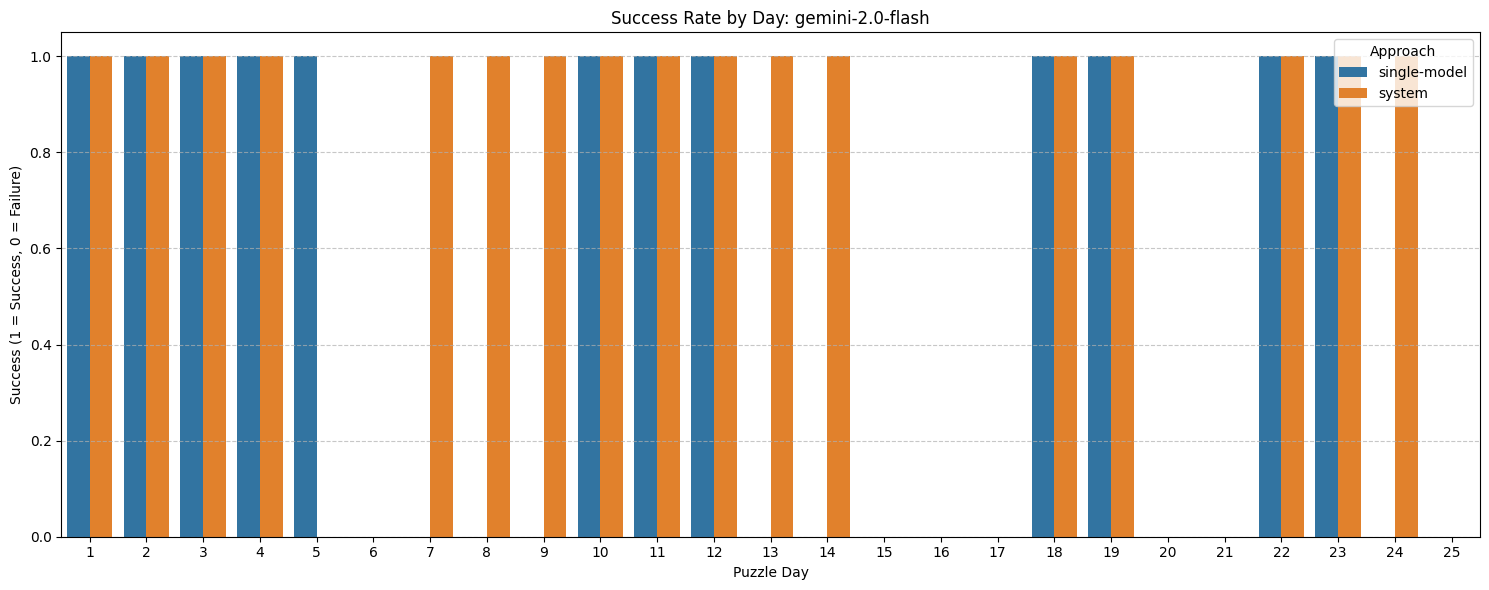

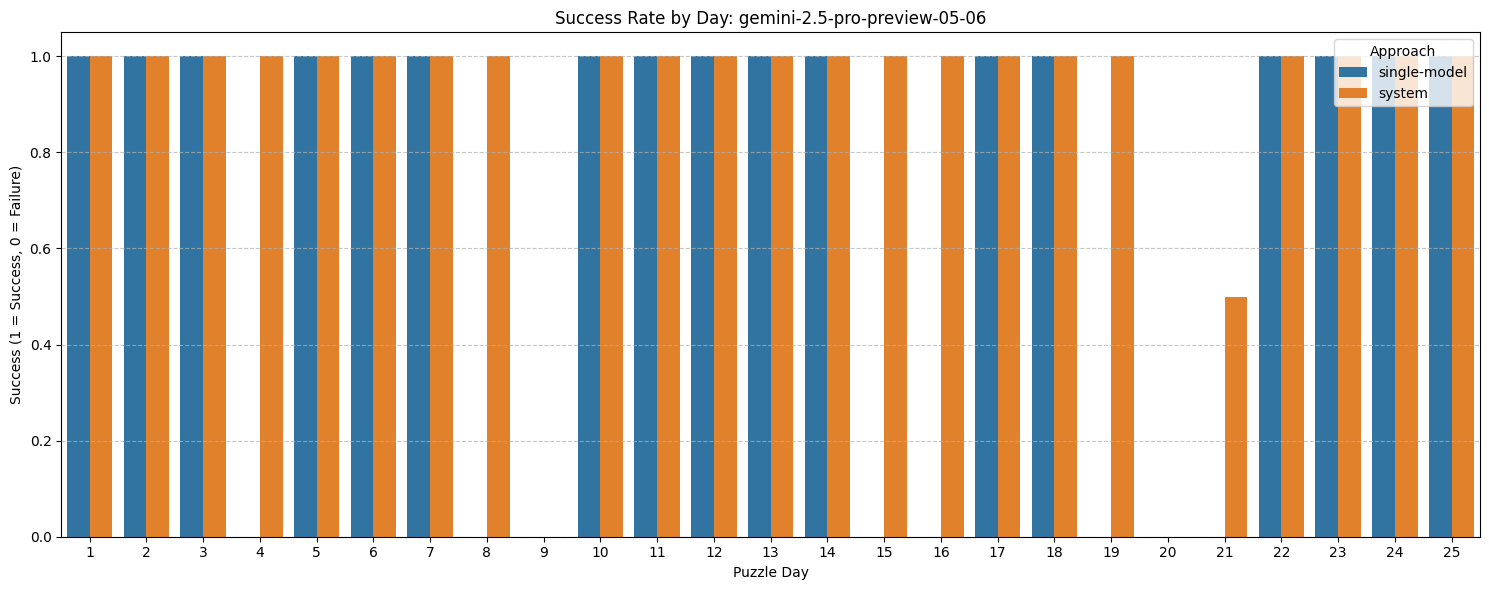

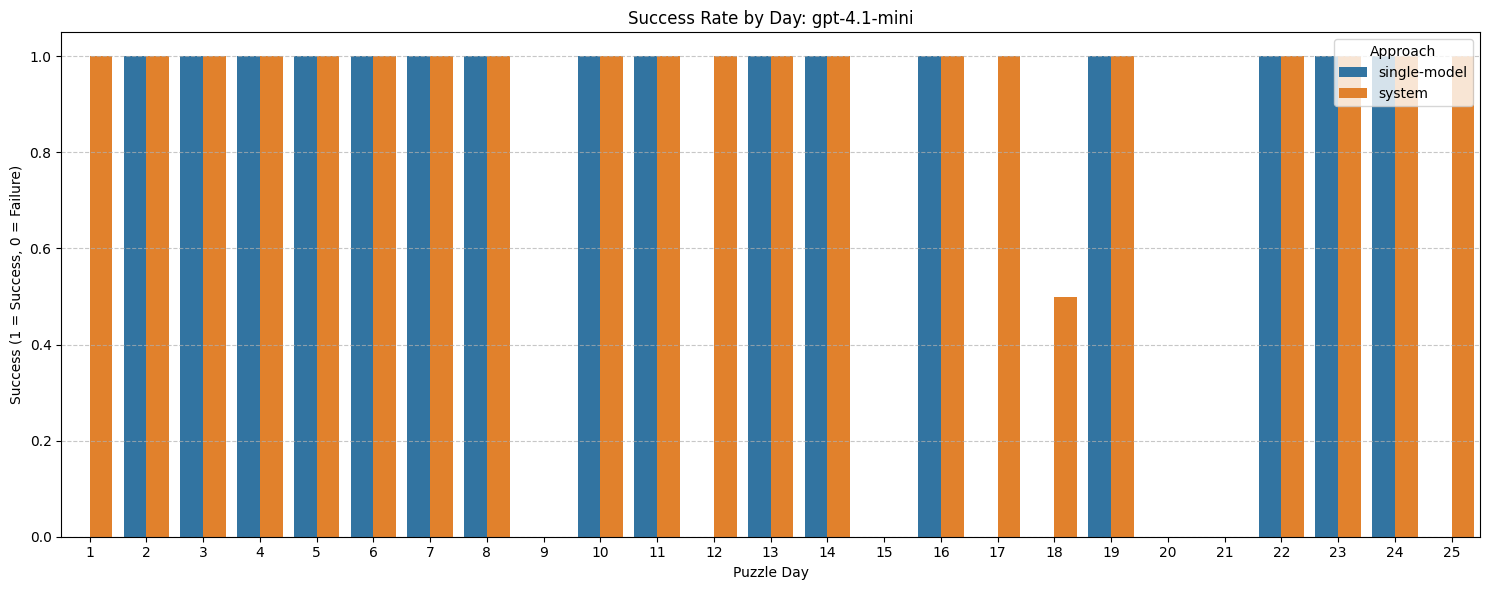

In [60]:
# For each model, create a separate chart
for model_name in df_filtered['model'].unique():
    model_data = df_filtered[df_filtered['model'] == model_name]
    
    plt.figure(figsize=(15, 6))
    sns.barplot(x='day', y='success', hue='approach', data=model_data, errorbar=None)
    plt.title(f'Success Rate by Day: {model_name}')
    plt.xlabel('Puzzle Day')
    plt.ylabel('Success (1 = Success, 0 = Failure)')
    plt.xticks(range(len(model_data['day'].unique())))
    plt.legend(title='Approach')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


In [ ]:
# Success rate per day 
puzzle_success_rate = (
    df.groupby("puzzle_id")["success"].mean().sort_values()
) # Sorts by least successful to most

print("\n--- Success Rate per Puzzle ---")
print(puzzle_success_rate)

# Plotting top N hardest puzzles
N_PUZZLES_TO_SHOW = 25 # Adjust as needed
plt.figure(figsize=(12, 7))
puzzle_success_rate.head(N_PUZZLES_TO_SHOW).plot(
    kind="barh", color=sns.color_palette("rocket_r")
)
plt.title(f"Top {N_PUZZLES_TO_SHOW} Hardest Puzzles (Lowest Overall Success Rate)")
plt.xlabel("Overall Success Rate")
plt.ylabel("Puzzle ID")
plt.tight_layout()
plt.show()


#### Time distribution (per model)

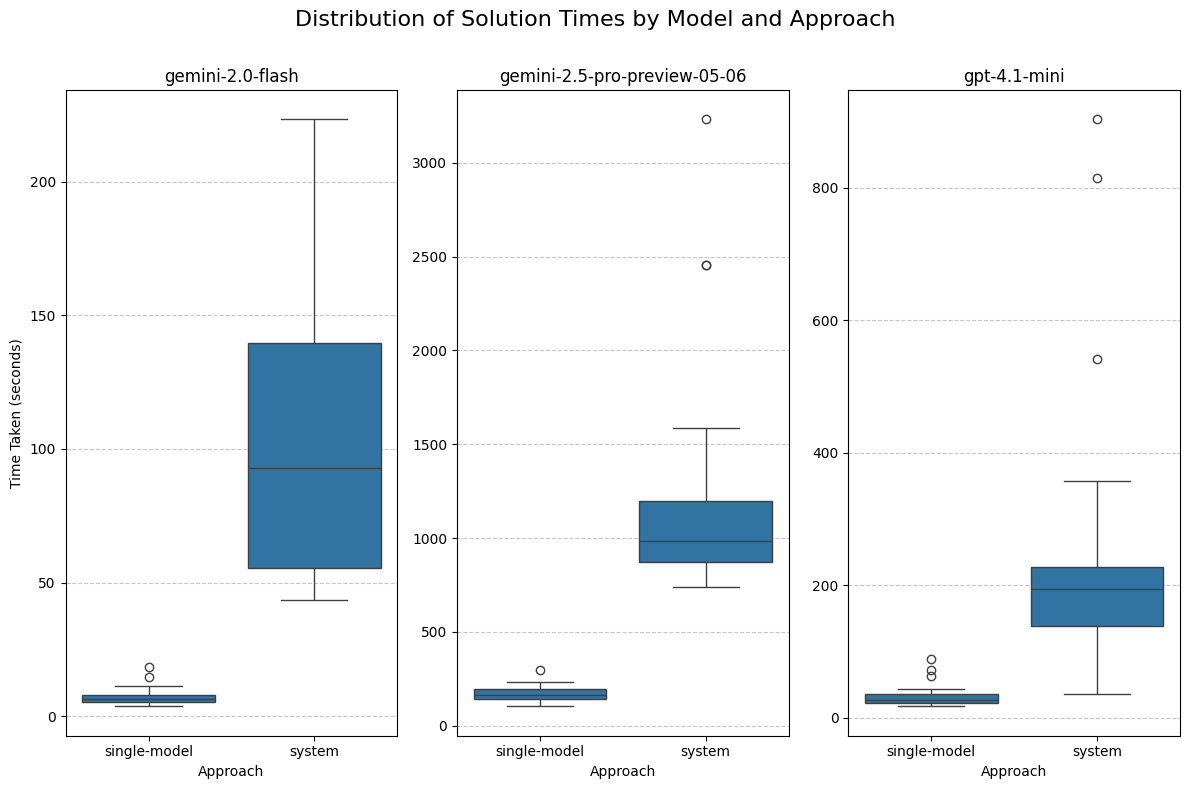

In [61]:
# Create boxplots for each model
plt.figure(figsize=(12, 8))
for i, model_name in enumerate(df_filtered['model'].unique()):
    plt.subplot(1, len(df_filtered['model'].unique()), i+1)
    
    model_data = df_filtered[df_filtered['model'] == model_name]
    sns.boxplot(x='approach', y='time_taken', data=model_data)
    plt.title(f'{model_name}')
    
    if i == 0:  # Only add y-label to the first subplot
        plt.ylabel('Time Taken (seconds)')
    else:
        plt.ylabel('')
    
    plt.xlabel('Approach')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle('Distribution of Solution Times by Model and Approach', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()


#### Success Rate VS Time 

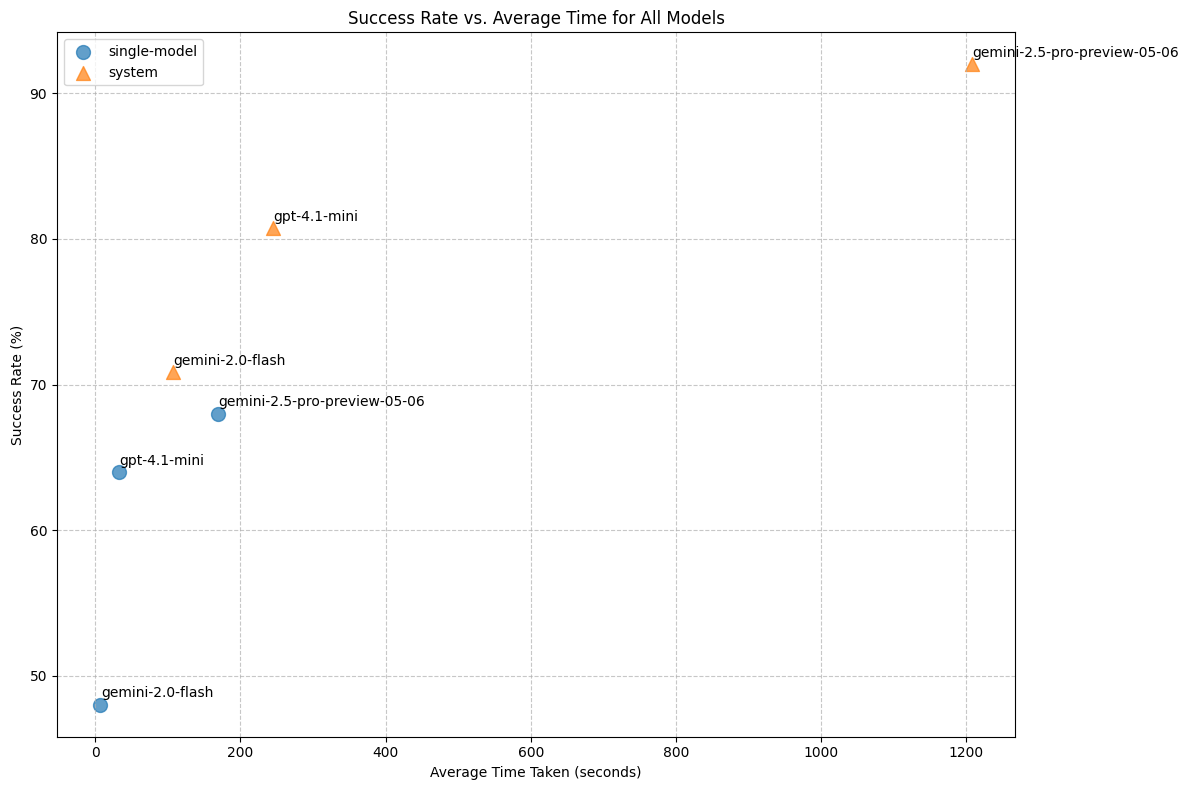

In [62]:
# Calculate success_rate and avg_time for each approach and model
tradeoff_data = df_filtered.groupby(['approach', 'model']).agg(
    success_rate=('success', 'mean'),
    avg_time=('time_taken', 'mean')
).reset_index()

# Convert success_rate to percentage
tradeoff_data['success_rate'] = tradeoff_data['success_rate'] * 100

# Create scatter plot
plt.figure(figsize=(12, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink']  # Add more as needed

for i, (approach, group) in enumerate(tradeoff_data.groupby('approach')):
    marker = 'o' if approach == 'single-model' else '^'
    plt.scatter(
        group['avg_time'], 
        group['success_rate'],
        s=100,
        alpha=0.7,
        marker=marker,
        label=f"{approach}",
    )
    
    # Add model name labels for each point
    for _, row in group.iterrows():
        plt.annotate(
            row['model'], 
            (row['avg_time']+0.5, row['success_rate']+0.5)
        )

plt.title('Success Rate vs. Average Time for All Models')
plt.xlabel('Average Time Taken (seconds)')
plt.ylabel('Success Rate (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


### Model `gemini-2.0-flash`

In [ ]:
# Investigate the results for gemini-2.0-flash
df_gem20_flash = df[df['model'] == 'gemini-2.0-flash']

In [54]:
# 1 day seems to be missing
# Filter for gemini-2.0-flash in the system approach
df_gem_system = df_filtered[(df_filtered['model'] == 'gemini-2.0-flash') & 
                            (df_filtered['approach'] == 'system')]

# Get the days that are present
present_days = set(df_gem_system['day'])

# Expected days (1-25)
all_days = set(range(1, 26))

# Find missing days
missing_days = all_days - present_days
print("Missing days for gemini-2.0-flash in the system approach:", missing_days)


Missing days for gemini-2.0-flash in the system approach: {6}


In [56]:
# Averages
results_per_day = df_gem20_flash.groupby('approach').agg(
    success_rate=('success', 'mean'), 
    avg_time_taken=('time_taken', 'mean')
).reset_index()

results_per_day

,approach,success_rate,avg_time_taken
0,single-model,0.480000,7.388300
1,system,0.708333,107.126905


In [39]:
# Do side by side comparison 
# Reshape the data to include each day
df_comp_gem20_flash = df_gem20_flash.pivot(index='day', columns='approach', values=['success', 'time_taken'])

# Flatten the multi-level column index for easier access
df_comp_gem20_flash.columns = ['_'.join(col).strip() for col in df_comp_gem20_flash.columns.values]

# Reset the index to make 'day' a column
df_comp_gem20_flash = df_comp_gem20_flash.reset_index()
df_comp_gem20_flash

,day,success_single-model,success_system,time_taken_single-model,time_taken_system
0,1,True,True,5.564193,45.201035
1,2,True,True,4.877627,49.976161
2,3,True,True,3.623321,43.277642
3,4,True,True,5.417661,55.734777
4,5,True,False,5.617599,186.303321
5,6,False,NaN,5.775475,NaN
6,7,False,True,4.24254,65.326288
7,8,False,True,6.240673,96.633115
8,9,False,True,11.274895,131.835612
9,10,True,True,6.012236,54.979762


In [40]:
df_comp_gem20_flash['success_comparison'] = df_comp_gem20_flash.apply(
    lambda row: 'Both succeeded' if row['success_single-model'] and row['success_system']
    else 'Single-model only' if row['success_single-model'] and not row['success_system']
    else 'System only' if not row['success_single-model'] and row['success_system']
    else 'Both failed',
    axis=1
)
df_comp_gem20_flash

,day,success_single-model,success_system,time_taken_single-model,time_taken_system,success_comparison
0,1,True,True,5.564193,45.201035,Both succeeded
1,2,True,True,4.877627,49.976161,Both succeeded
2,3,True,True,3.623321,43.277642,Both succeeded
3,4,True,True,5.417661,55.734777,Both succeeded
4,5,True,False,5.617599,186.303321,Single-model only
5,6,False,NaN,5.775475,NaN,System only
6,7,False,True,4.24254,65.326288,System only
7,8,False,True,6.240673,96.633115,System only
8,9,False,True,11.274895,131.835612,System only
9,10,True,True,6.012236,54.979762,Both succeeded


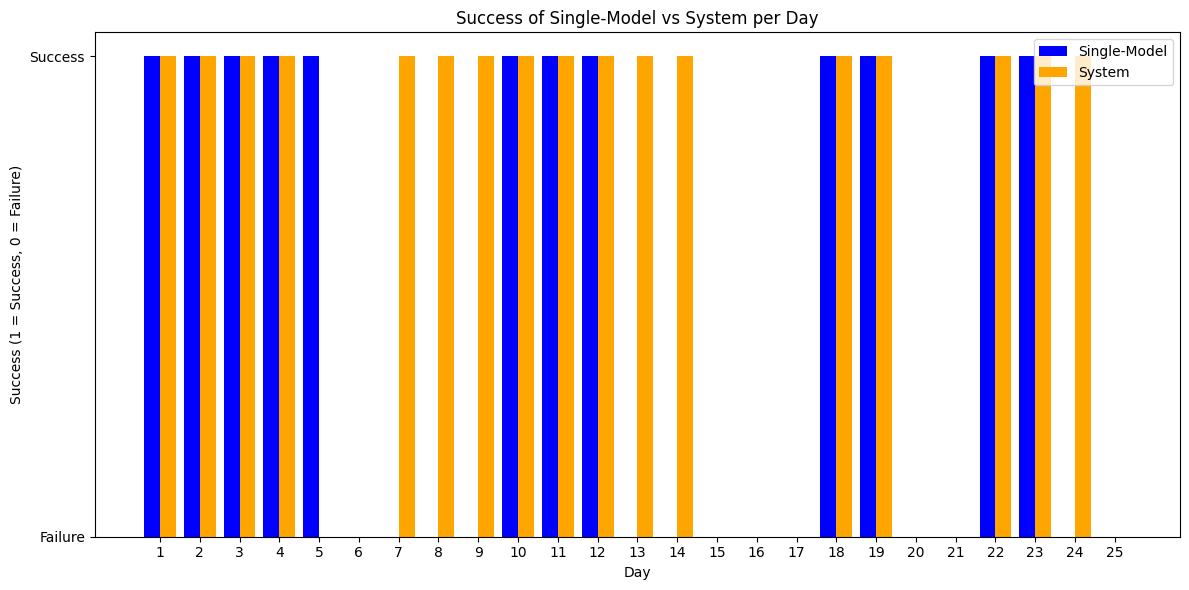

In [42]:
# Prepare the data
days = df_comp_gem20_flash['day']
success_single_model = df_comp_gem20_flash['success_single-model']
success_system = df_comp_gem20_flash['success_system']

# Set the width of the bars
bar_width = 0.4

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(days - bar_width / 2, success_single_model, width=bar_width, label='Single-Model', color='blue')
plt.bar(days + bar_width / 2, success_system, width=bar_width, label='System', color='orange')

# Add labels and title
plt.xlabel('Day')
plt.ylabel('Success (1 = Success, 0 = Failure)')
plt.title('Success of Single-Model vs System per Day')
plt.xticks(days)  # Use the 'day' column directly for x-axis ticks
plt.yticks([0, 1], ['Failure', 'Success'])  # Label the y-axis as Failure/Success
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


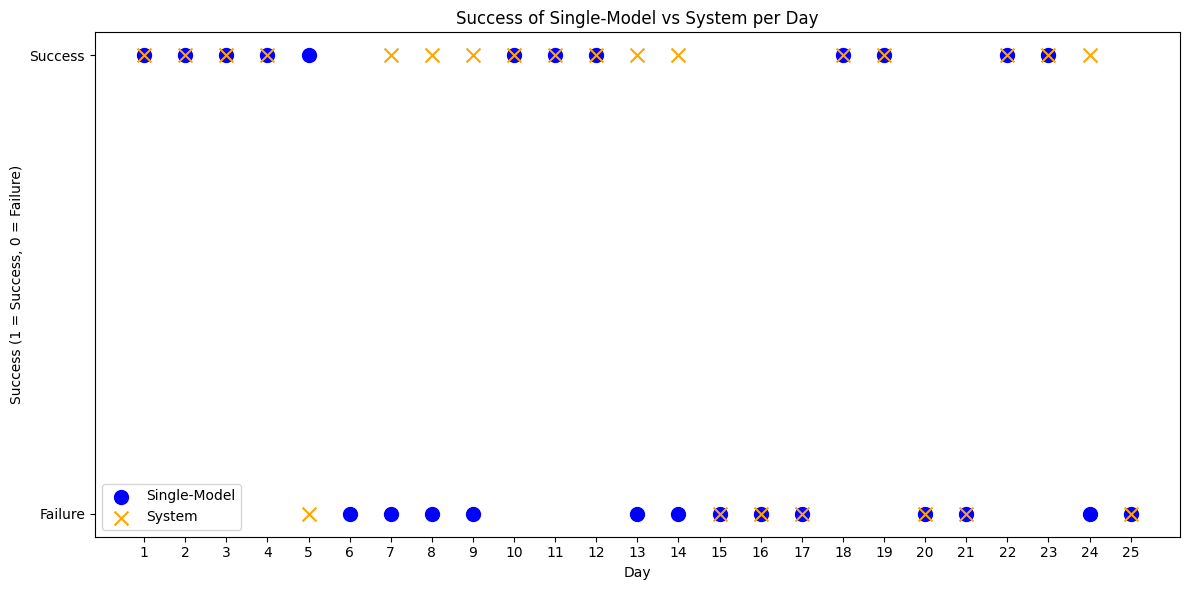

In [43]:
# Create the scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(days, success_single_model, label='Single-Model', color='blue', marker='o', s=100)
plt.scatter(days, success_system, label='System', color='orange', marker='x', s=100)

# Add labels and title
plt.xlabel('Day')
plt.ylabel('Success (1 = Success, 0 = Failure)')
plt.title('Success of Single-Model vs System per Day')
plt.xticks(days)  # Use the 'day' column directly for x-axis ticks
plt.yticks([0, 1], ['Failure', 'Success'])  # Label the y-axis as Failure/Success
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [45]:
# Create a table showing success for both approaches
success_table = df_comp_gem20_flash[['day', 'success_single-model', 'success_system']]

# Add a column to compare success (e.g., both succeeded, one failed, etc.)
success_table['success_comparison'] = success_table.apply(
    lambda row: 'Both succeeded' if row['success_single-model'] and row['success_system']
    else 'Single-model only' if row['success_single-model'] and not row['success_system']
    else 'System only' if not row['success_single-model'] and row['success_system']
    else 'Both failed',
    axis=1
)

success_table

/tmp/ipykernel_27278/877376504.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  success_table['success_comparison'] = success_table.apply(


,day,success_single-model,success_system,success_comparison
0,1,True,True,Both succeeded
1,2,True,True,Both succeeded
2,3,True,True,Both succeeded
3,4,True,True,Both succeeded
4,5,True,False,Single-model only
5,6,False,NaN,System only
6,7,False,True,System only
7,8,False,True,System only
8,9,False,True,System only
9,10,True,True,Both succeeded
